# SPASE Record Analysis - How to Use (Beginner)
Author: Zach Boquet

## Introduction 
For documentation on how to add to this project, view the related notebook named "HowToAdd.ipynb" <br>
<br>
This project provides a method to analyze FAIR for the SPASE records in the NumericalData and DisplayData categories.<br>

This notebook shows you how to convert desired SPASE record fields into a SQLite database. The desired fields correspond to metadata extracted from XML files using ElementTree. Also shown is how to query data from that database. <br> 
- The tutorial I used to implement ElementTree is <a href="https://realpython.com/python-xml-parser/" target="_blank">https://realpython.com/python-xml-parser/</a>. 
- If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Note that this code was extensively tested on the NASA SPASE Github repo. However, results are not guaranteed when running on other SPASE Github repos. This code was tested in Summer 2024 on SPASE version 2.6.1*

This program takes ~2 seconds to fully run on over the 3000 records stored in the database.

## Installation
First, make sure these scripts are installed. Please see the readme file for instructions. Then, clone the NASA SPASE Github Repository <a href="https://github.com/hpde/NASA/tree/master" target="_blank">https://github.com/hpde/NASA/tree/master</a> by executing the following code. Lastly, make sure you have the necessary packages and Python scripts imported below, which can be found in the same repo you found this notebook, linked again here: <a href="https://github.com/Kurokio/HDRL-Internship-2024" target="_blank">https://github.com/Kurokio/HDRL-Internship-2024</a>.

In [ ]:
# clone NASA SPASE Github Repo into the directory above this tutorial.
#! git clone -b master --single-branch --depth=1 https://github.com/hpde/NASA ../../NASA

In [ ]:
# show your current directory
#! pwd

## Loading our database and understanding the structure

This code block loads the pre-built and already populated database and also gives insight into how it is structured.

### Loading the Existing Database
A pre-built database is included in this repository. You can use this database as a starting point.

In [ ]:
from Scripts import create_sqlite_database

help(create_sqlite_database)

In [ ]:
# input abs path of database file you wish to load from, located one directory above this notebook
conn = create_sqlite_database("../SPASE_Data_20240716.db")

### Understanding the Database Structure
The graphic below shows the contents of the four tables created by this program. The main topic of the tables are in orange, the column contents are in yellow, and notes are in blue. The exact names are shown in the code blocks below.


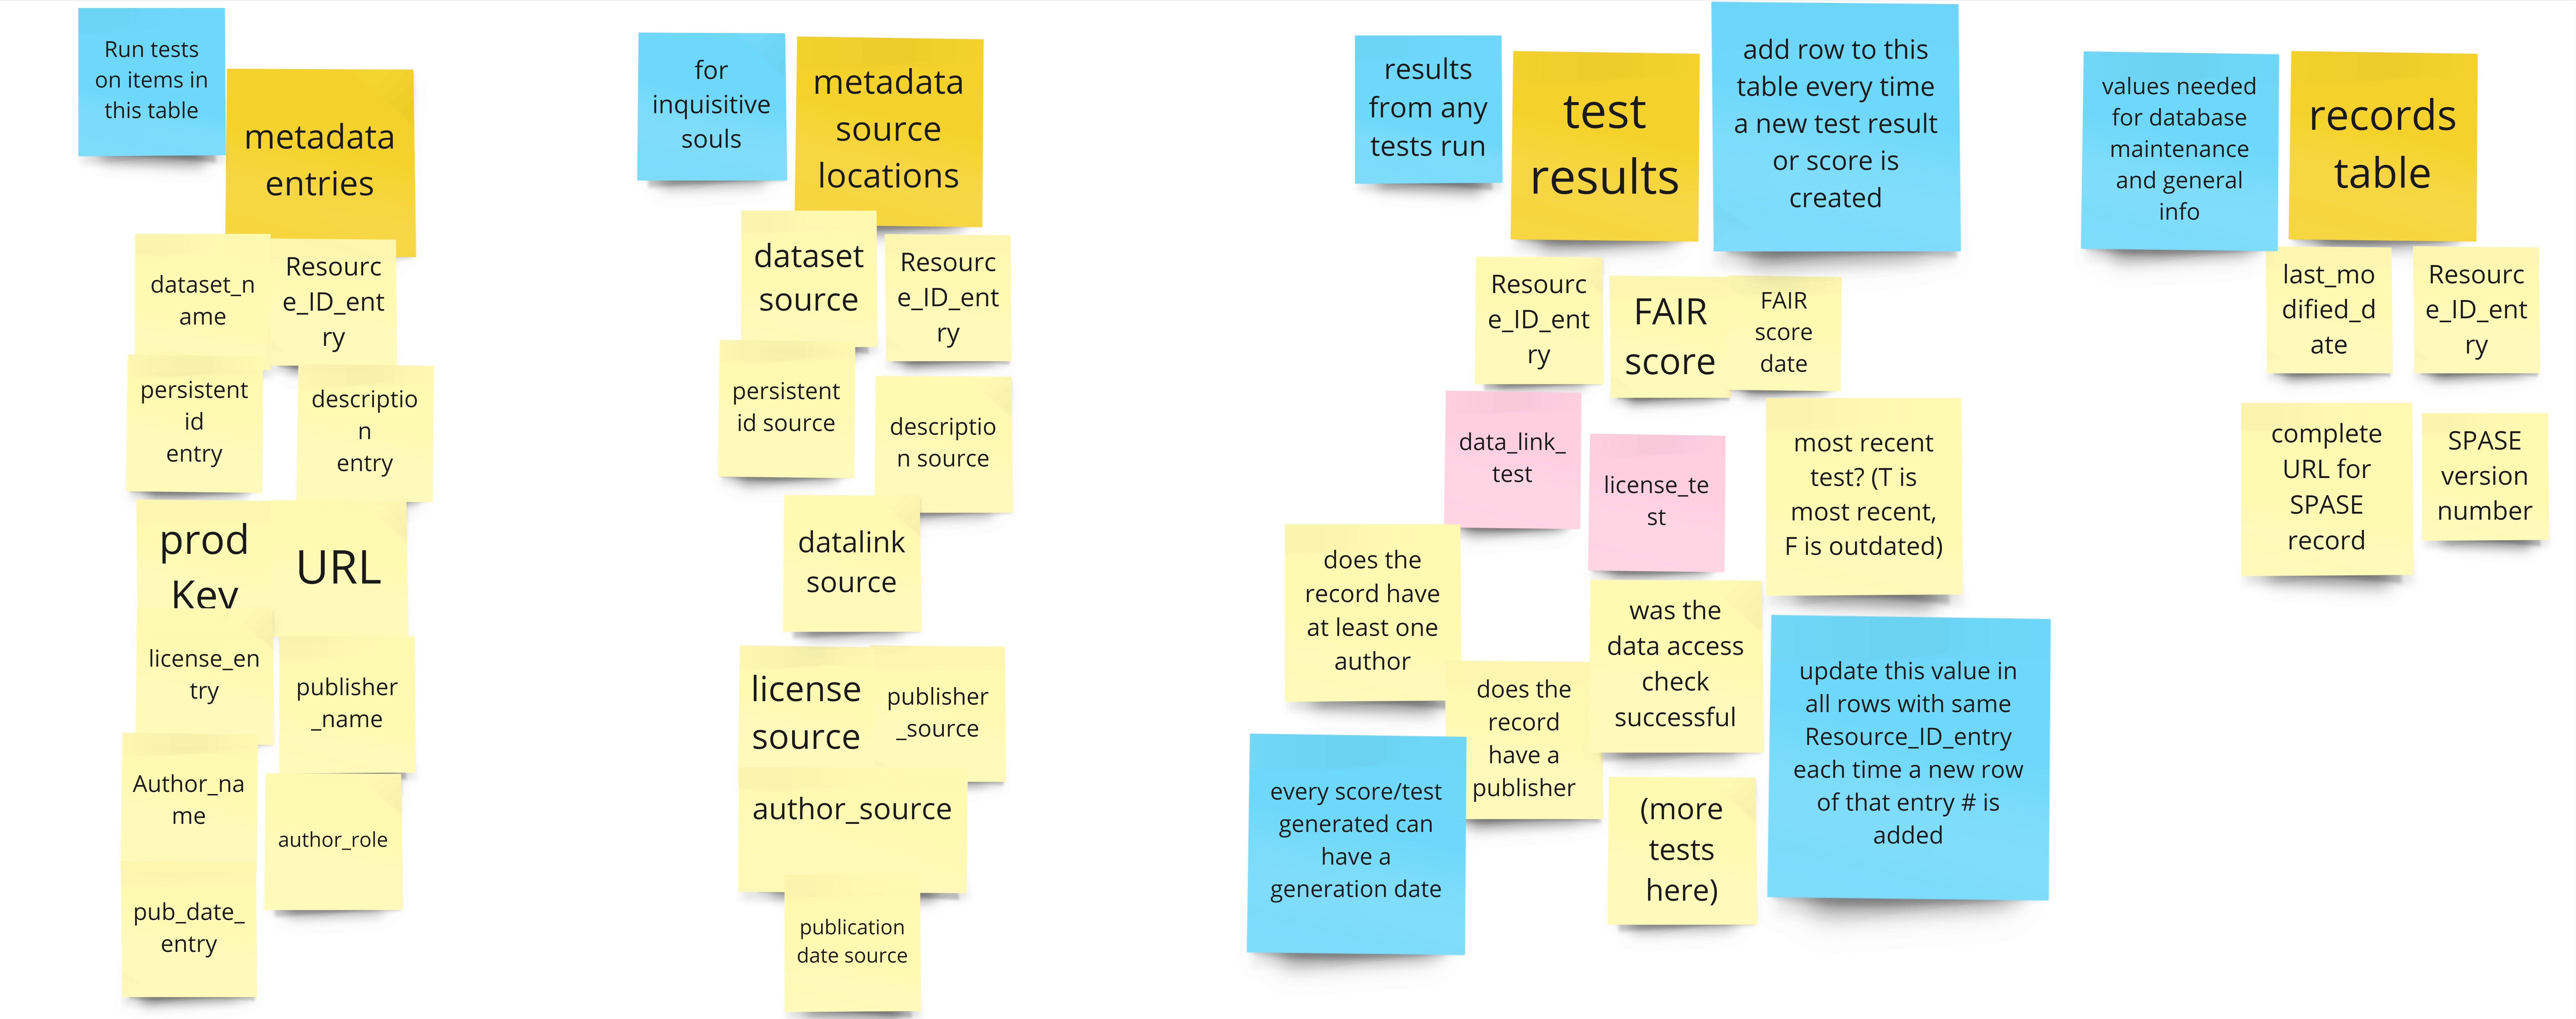

This code block shows you all the table names and their column names in the database that was used.

In [ ]:
from Scripts import databaseInfo

help(databaseInfo)

In [ ]:
name_dict = databaseInfo(conn)

## Executing Analysis Tests and Viewing the Results 
In this code block, we perform calls to the View function in main to get the Counts and ID's of the SPASE records that pass each analysis test. 
These analysis tests include links that have: <br> 

- authors <br>
- publishers <br>
- publication years <br>
- dataset names <br>
- licenses <br>
- URLs <br>
- NASA URLs <br>
- persistent identifiers <br>
- descriptions <br>
- citation info <br>
- DCAT-3 compliance info.<br>

### Executing the Analysis Tests

In [ ]:
# this function returns all records that pass associated tests 
# and prints the counts of those that pass the test specified in the argument
from Scripts import View

help(View)

In [ ]:
# example that returns values for all tests
records = View(conn)

In [ ]:
# understanding the structure of the records dictionary returned
# The name of the metadata and the number of records with that field are shown below.
print("Metadata Name, Number of records, Example record name")
print("-----------------------------------------------------")
for key in records.keys():
    if len(records[key]) > 0:
        print(key, ',', len(records[key]), ',', records[key][0])
    else:
        print(key, ',', len(records[key]), ', N/A')

### Plotting the Analysis Results

In [ ]:
# This function creates a bar chart for the metadata fields checked.
from Scripts import MetadataBarChart

help(MetadataBarChart)

In [ ]:
# Plotting the bar chart for all records 
fig = MetadataBarChart(conn)

In [ ]:
# Plotting the percent version of the same bar chart
fig = MetadataBarChart(conn, percent = True)

## Plotting the FAIR Score Distributions
This code creates 2 bar charts based on the TestResults table, one showing FAIR Scores for all records and one showing the FAIR Scores for only those records with NASA URLs. The FAIR Scores are calculated according to the following algorithm:<br>

- +1 for author
- +1 for dataset name
- +1 for publication year
- +1 for publisher
- +1 for all citation info
- +1 for description
- +1 for PID
- +1 for DCAT3-US compliance
- +1 for license
- +1 for NASA URL <br>
======================= <br>
- Total Possible Points of 10

*Note that this alogrithm is expected to change*

If interested in viewing the FAIR Score for a particular record, refer to the column-specific queries section further below.

In [ ]:
from Scripts import FAIR_Chart

help(FAIR_Chart)

In [ ]:
# for all records
fig = FAIR_Chart(conn)

## How to do your own queries 
This section gives examples of how to query the database for row specific and column specific queries. Also provided are brief explanations of some of the SQLite syntax and also an example of a complex query for both categories. <br>

If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Disclaimer: Not all authors are provided, as checks were only done to find if an allowed author exists.* 
<br>
**Also note that when a SPASE record has multiple product keys for one URL or multiple URLs in general, each URL/product key gets their own entry into the table. This is why there may be 'duplicate entries' in the database.**

### Record Specific Queries

This section describes how to get data with queries based on records/rows.

In [ ]:
from Scripts import execution

help(execution)

> Ex: How to get a ResourceID

> - Use """SELECT columnName FROM TableName WHERE columnName = x""" where x is of proper data type.

In [ ]:
# Gets the SPASE ID from the 10th row
stmt = """ SELECT SPASE_id FROM MetadataEntries WHERE rowNum = 10 """
items = execution(stmt, conn)
items

> Ex: Get ResourceID by specifying the xml file name

> - Use "LIKE '%text%'" instead of '= x' for when you need to query on partial info.

> - SQLite uses the '%' as the multi-character wildcard and '_' as the single character wildcard.

> - Use DISTINCT to prevent duplicate rows.

In [ ]:
# Gets a list of SPASE IDs that have the given string in the ID
# This example gets all 100 of the SPASE IDs from MMS with Burst in the ID.
stmt = """ SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE SPASE_id LIKE '%/MMS/%/Burst/%' """
items = execution(stmt, conn)
print(len(items))

> Ex: Searching table for ResourceID using a specific value of a column

In [ ]:
# This example looks for the SPASE ID that has the given text in the dataset name.
ds = "Interball Aurora MAG 2-min Key Parameters"
stmt = f""" SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE datasetName = '{ds}' """
items = execution(stmt, conn)
items

> Ex: How to get all data for a SPASE record using the ResourceID
> - Put 'multiple' as the second optional arg for execution when selecting more than 1 item.

>> This example prints out the following data in a list of tuples, where each tuple is a distinct row in the table. The tuples follow the following printout format:
>> - rowNum
>> - SPASE_id
>> - author
>> - authorRole (if relevant)
>> - publisher
>> - publication year
>> - datasetName
>> - license
>> - url (if NASA URL)
>> - prodKey
>> - description
>> - PID

In [ ]:
# Confirm that the dataset name for the SPASE ID matches.
# This SPASE ID has information on four rows, so the dataset name for all four rows is printed.
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT datasetName FROM MetadataEntries WHERE SPASE_id = '{ID}' """
rows = execution(stmt, conn)
rows

In [ ]:
# Now that you have a SPASE_ID, this example gets all the metadata for that record
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT * FROM MetadataEntries WHERE SPASE_id = '{ID}' """
rows = execution(stmt, conn, "multiple")

In [ ]:
# Retrieving the database sturcture to understand the types of items printed
from Scripts import databaseInfo

name_dict = databaseInfo(conn, print_flag=False)
for row in rows:
    for name, item in zip(name_dict['MetadataEntries'], row):
        print(name, ':', item)
    print()

> To get the actual description, use the SPASE_DataPrinter function

In [ ]:
from Scripts import MetadataPrinter

help(MetadataPrinter)

In [ ]:
MetadataPrinter(ID, fields = ["description"])

> Ex: How to get the Fair Score for a record

In [ ]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT DISTINCT(FAIR_Score) FROM TestResults WHERE SPASE_id = '{ID}' """
item = execution(stmt, conn)
item

In [ ]:
# get all the test result fields for a record (used to calculate the FAIR score)
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT * FROM TestResults WHERE SPASE_id = '{ID}' """
items = execution(stmt, conn, "multiple")

In [ ]:
# Retrieving the database structure to understand the types of items printed
from Scripts import databaseInfo

name_dict = databaseInfo(conn, print_flag=False)
for row in items:
    for name, item in zip(name_dict['TestResults'], row):
        print(name, ':', item)

### Column Specific Queries
This section describes how to get data with queries based on the column values.

> Ex: How many records do not have a NASA URL?

In [ ]:
stmt = """SELECT COUNT(DISTINCT(SPASE_id)) FROM TestResults WHERE has_NASAurl = 0"""
items = execution(stmt, conn)
items

> Ex: What are some examples of SPASE_id's of the records that do not have a NASA URL?
> - Use optional LIMIT x at end to limit how many items are selected.

In [ ]:
stmt = """SELECT DISTINCT(SPASE_id) FROM TestResults WHERE has_NASAurl = 0 LIMIT 10"""
items = execution(stmt, conn)
items

> Ex: How many records have SDAC or SPDF as a publisher?

In [ ]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM MetadataEntries 
                        WHERE (publisher LIKE "%SDAC" OR publisher LIKE 
                               "%Solar Data Analysis Center" 
                               OR publisher LIKE "%SPDF" OR publisher LIKE 
                               "%Space Physics Data Facility")"""
items = execution(stmt, conn)
items

> Ex: How did records in a certain directory do in terms of FAIR scores?
> - Notice that since we are only interested in the most up-to-date FAIR scores, we add the "MostRecent = 'T'" condition.

In [ ]:
stmt = """SELECT SPASE_id, FAIR_Score FROM TestResults 
                WHERE SPASE_id LIKE '%/ACE/%' AND MostRecent = 'T' LIMIT 10"""
print("Format is as follows: (SPASE_id, FAIR_Score)")
items = execution(stmt, conn, "multiple")
for row in items:
    print(row[0] + ", " + str(row[1]))

> Ex: How many records have a FAIR Score of x?

In [ ]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults WHERE FAIR_Score = 9 """
items = execution(stmt, conn)
items